<a href="https://colab.research.google.com/github/jajapuramshivasai/Neuromorphic-LSM-QT/blob/main/proof_of_concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

quantum state tomographys has wide applications in quantum sensing, algorithm design and verification and analysis/benchmarking of qunatum devices. for example it is a important task in quantum linear solvers to extract final solution as real amplitude vector from measurement data. By using neuromorphic LSM we can directly implement the quromorphic system with quantum reservoir for holding input quantum data and the applying quantum variational auto encoder and then implementing neuromorphic network that is directly connected to measurement readouts on a single chip using tech like for example spintronic hardware . this hetrogenous archticture enables ultrafast operations witout any bottlenecks in sub microsecond time scales.

_____________

---------
```markdown
# Refined Quantum-Neuromorphic Tomography Model



[Start]
│
▼
[Quantum State Preparation]
│
│  (Prepare quantum state |ψ⟩, e.g., GHZ)
▼
[Quantum Circuit & Autoencoder]
│
│ (Optionally compress or encode the quantum state)
▼
[Measurement in Z Basis]
│
│ (Sequential bitstring measurements over multiple shots,
│  e.g., "101", "010", "001", ...)
▼
[Bitstring to Spike Vector Conversion]
│
│ (Each bitstring converted to binary spike vector,
│  bit=1 ⇒ neuron fires, bit=0 ⇒ no spike)
▼
[Sequential Input to Neuromorphic Reservoir]
│
│ (Spike vectors fed timestep-wise to reservoir neurons)
▼
[Neuromorphic Reservoir Dynamics]
│
│ (Recurrent spiking dynamics, local Hebbian learning
│  updates synaptic weights after each spike input)
▼
[Aggregate Reservoir State]
│
│ (Reservoir firing rates accumulated across shots)
▼
[Classical Decoder]
├─────────────┬───────────────┐
│             │               │
│             │               │
[SNN Decoder] [ANN Decoder] [Classical Regression (e.g., Ridge, ElasticNet)]
│             │               │
└─────────────┴───────────────┘
↓
[Output Reconstruction]
│
│ (Predicted quantum state recovered: real amplitudes or density matrices)
▼
[Evaluate Fidelity, Metrics, and Error]
│
▼
[End]



## Explanation:

- **Quantum State Preparation**  
  Prepare target quantum states (e.g., GHZ) using real amplitude encoding, MottonenStatePreparation or variational autoencoders on input quantum data.

- **Measurement in Z Basis**  
  Perform sequential projective measurements in the computational basis to generate bitstring outcomes.

- **Bitstring to Spike Vector Conversion**  
  Convert each measured bitstring into a binary spike vector: bits with '1' cause corresponding neurons to spike; bits with '0' remain silent.

- **Neuromorphic Reservoir**  
  Feed the spike vectors sequentially into a neuromorphic liquid state machine reservoir with recurrent spiking dynamics and Hebbian/other synaptic plasticity.

- **Classical Decoder Options**  
  Decode aggregated reservoir firing rates using one of:  
  - Spiking Neural Network (SNN) decoder trained with surrogate gradients,  
  - Artificial Neural Network (ANN) decoder with classical backpropagation,  
  - Classical regression models (e.g., Ridge or ElasticNet).  

- **Output Reconstruction & Evaluation**  
  Reconstruct real quantum state amplitudes or full density matrices; compute fidelity and error metrics for accuracy assessment.

---

This architecture combines quantum state encoding, neuromorphic temporal memory, and flexible classical/neural decoding, enabling efficient and scalable quantum state tomography.
```

----------


In [1]:
!pip install pennylane
!pip install Brian2
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 8.4 MB/s eta 0:00:00


[Start]
   │
   ▼
[Quantum State Preparation]
   │
   │  (Prepare quantum state |ψ⟩, e.g., GHZ)
   ▼
[Quantum Circuit / Autoencoder]
   │
   │ (Optionally compress or encode the quantum state)
   ▼
[Measurement in Z Basis]
   │
   │ (Sequential bitstring measurements over multiple shots,
   │  e.g., "101", "010", "001", ...)
   ▼
[Bitstring to Spike Vector Conversion]
   │
   │ (Each bitstring converted to binary spike vector,
   │  bit=1 ⇒ neuron fires, bit=0 ⇒ no spike)
   ▼
[Sequential Input to Neuromorphic Reservoir]
   │
   │ (Spike vectors fed timestep-wise to reservoir neurons)
   ▼
[Neuromorphic Reservoir Dynamics]
   │
   │ (Recurrent spiking dynamics, local Hebbian learning
   │  updates synaptic weights after each spike input)
   ▼
[Aggregate Reservoir State]
   │
   │ (Reservoir firing rates accumulated across shots)
   ▼
[Classical Decoder]
   ├─────────────┬───────────────┐
   │             │               │
   │             │               │
[SNN Decoder] [ANN Decoder] [Classical Regression (e.g., Ridge, ElasticNet)]
   │             │               │
   └─────────────┴───────────────┘
            ↓
[Output Reconstruction]
   │
   │ (Predicted quantum state recovered: real amplitudes or density matrices)
   ▼
[Evaluate Fidelity, Metrics, and Error]
   │
   ▼
[End]


Hyperparameters:
Number of qubits: 3
Reservoir dimension: 100
Training samples max: 100
Sample step size: 5


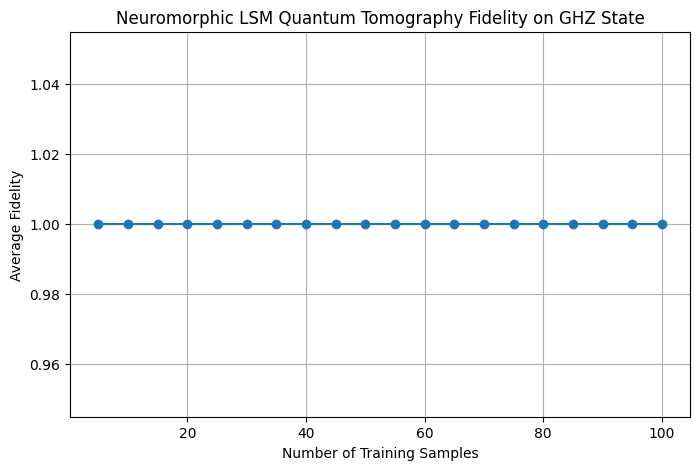

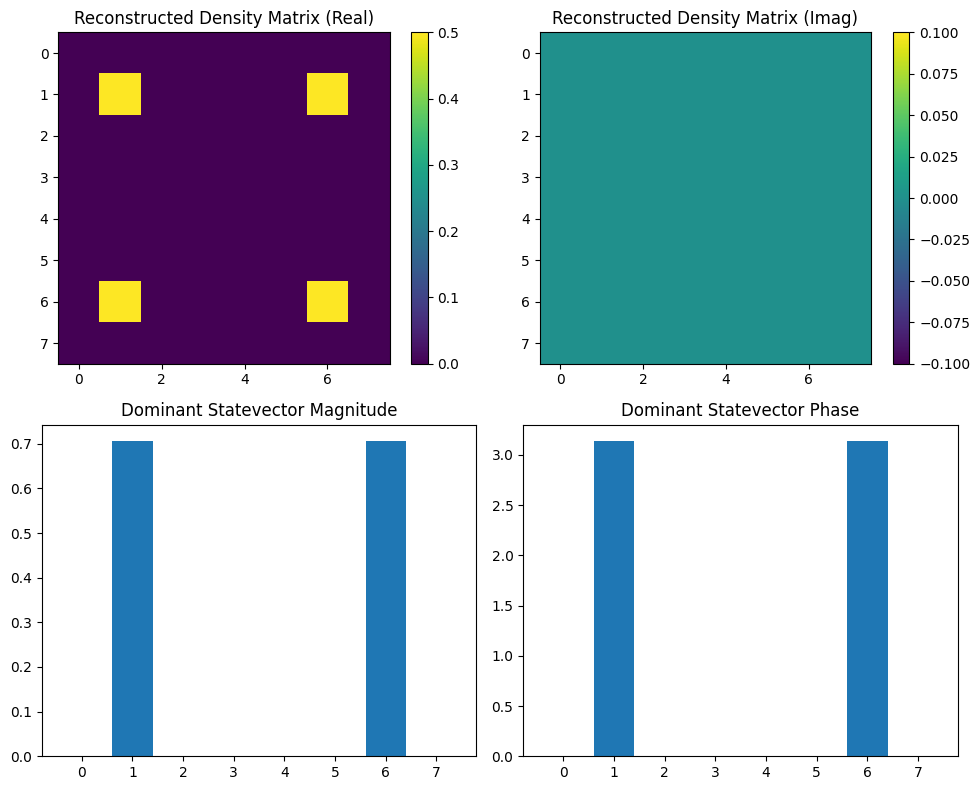

In [12]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

# Hyperparameters
num_qubits = 3
reservoir_dim = 100
max_samples = 100
sample_step = 5

print("Hyperparameters:")
print(f"Number of qubits: {num_qubits}")
print(f"Reservoir dimension: {reservoir_dim}")
print(f"Training samples max: {max_samples}")
print(f"Sample step size: {sample_step}")

# PennyLane device
dev = qml.device("default.qubit", wires=num_qubits)

# GHZ state preparation circuit
@qml.qnode(dev)
def ghz_state():
    qml.Hadamard(wires=0)
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.PauliX(wires=num_qubits - 1)
    return qml.state()

# Simple neuromorphic LSM implementation
class SimpleNeuromorphicLSM:
    def __init__(self, input_dim, reservoir_dim):
        self.W_in = np.random.normal(0, 1, (reservoir_dim, input_dim))
        self.W_res = np.random.normal(0, 1, (reservoir_dim, reservoir_dim))
        spectral_radius = 1.2
        self.W_res *= spectral_radius / np.max(np.abs(np.linalg.eigvals(self.W_res)))
        self.reservoir_dim = reservoir_dim

    def run(self, inputs):
        n_samples = inputs.shape[0]
        res_states = np.zeros((n_samples, self.reservoir_dim))
        res = np.zeros(self.reservoir_dim)
        for i in range(n_samples):
            res = np.tanh(self.W_in @ inputs[i] + self.W_res @ res)
            res_states[i] = res
        return res_states

# Convert statevector to density matrix
def state_to_dm(state_vec):
    return np.outer(state_vec, np.conj(state_vec))

# Compute fidelity batch
def fidelity_batch(true_dm, pred_dm, dim=2**num_qubits):
    fidelities = []
    for t, p in zip(true_dm, pred_dm):
        t_dm = t[:dim*dim].reshape((dim, dim)) + 1j * t[dim*dim:].reshape((dim, dim))
        p_dm = p[:dim*dim].reshape((dim, dim)) + 1j * p[dim*dim:].reshape((dim, dim))
        f = qml.math.fidelity(t_dm, p_dm)
        fidelities.append(f)
    return np.array(fidelities)

# Lists for sample size and fidelity results
num_samples_list = list(range(sample_step, max_samples + 1, sample_step))
avg_fidelities = []

for num_samples in num_samples_list:
    # Generate GHZ states (all the same, repeated)
    ghz_states = np.array([ghz_state() for _ in range(num_samples)])
    # Density matrices
    dms = np.array([state_to_dm(st) for st in ghz_states])
    # Flatten input and target
    inputs = np.hstack([ghz_states.real, ghz_states.imag])
    targets = np.hstack([dms.real.reshape(num_samples, -1), dms.imag.reshape(num_samples, -1)])

    # Initialize neuromorphic LSM and run
    lsm = SimpleNeuromorphicLSM(input_dim=inputs.shape[1], reservoir_dim=reservoir_dim)
    res_states = lsm.run(inputs)

    # Ridge regression training
    reg = Ridge()
    reg.fit(res_states, targets)

    # Predict and evaluate fidelity
    pred_targets = reg.predict(res_states)
    fidelities = fidelity_batch(targets, pred_targets)
    avg_fidelities.append(np.mean(fidelities))

# Plot average fidelity vs number of training samples
plt.figure(figsize=(8, 5))
plt.plot(num_samples_list, avg_fidelities, marker='o')
plt.title('Neuromorphic LSM Quantum Tomography Fidelity on GHZ State')
plt.xlabel('Number of Training Samples')
plt.ylabel('Average Fidelity')
plt.grid(True)
plt.show()

# Visualize the reconstructed state and density matrix for the last (max) sample count
dim = 2**num_qubits
pred_dm_complex = pred_targets[0, :dim*dim].reshape((dim, dim)) + 1j * pred_targets[0, dim*dim:].reshape((dim, dim))

# Extract dominant eigenvector (closest statevector)
eigvals, eigvecs = np.linalg.eigh(pred_dm_complex)
dominant_statevector = eigvecs[:, np.argmax(eigvals)]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

im1 = axs[0, 0].imshow(pred_dm_complex.real, cmap='viridis')
axs[0, 0].set_title('Reconstructed Density Matrix (Real)')
plt.colorbar(im1, ax=axs[0, 0])

im2 = axs[0, 1].imshow(pred_dm_complex.imag, cmap='viridis')
axs[0, 1].set_title('Reconstructed Density Matrix (Imag)')
plt.colorbar(im2, ax=axs[0, 1])

axs[1, 0].bar(range(dim), np.abs(dominant_statevector))
axs[1, 0].set_title('Dominant Statevector Magnitude')

axs[1, 1].bar(range(dim), np.angle(dominant_statevector))
axs[1, 1].set_title('Dominant Statevector Phase')

plt.tight_layout()
plt.show()


Device: cpu
Qubits: 3, Reservoir size: 100, Time steps: 50, Samples: 50
Average fidelity: 1.0000
Std fidelity: 0.0000


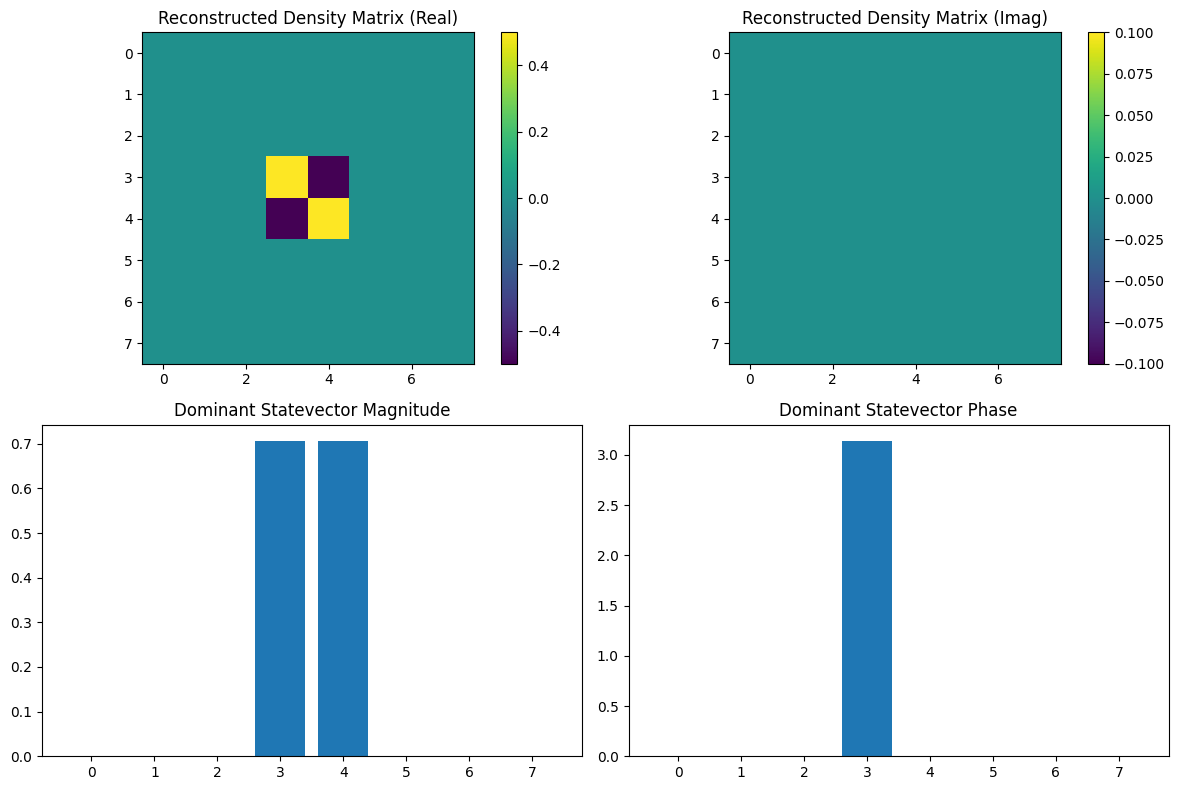

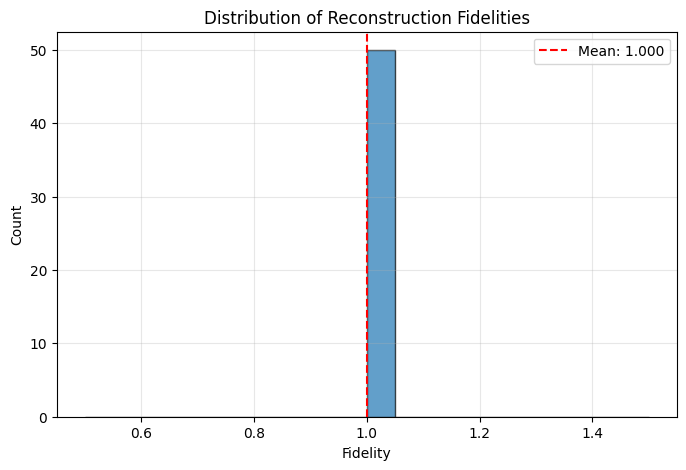

In [22]:
# Installation (run if not installed):
# pip install snntorch pennylane scikit-learn matplotlib torch

import torch
import torch.nn as nn
import snntorch as snn
from snntorch import spikegen, surrogate
import pennylane as qml
from pennylane import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_qubits = 3
input_size = 2 ** num_qubits
reservoir_size = 100
time_steps = 50
num_training_samples = 50
measurement_shots = 1000
max_rate_hz = 100

print(f"Device: {device}")
print(f"Qubits: {num_qubits}, Reservoir size: {reservoir_size}, Time steps: {time_steps}, Samples: {num_training_samples}")

# PennyLane quantum measurement sampling
dev_meas = qml.device("default.qubit", wires=num_qubits, shots=measurement_shots)
dev_state = qml.device("default.qubit", wires=num_qubits, shots=None)

@qml.qnode(dev_meas)
def sample_measurement():
    qml.Hadamard(wires=0)
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    return qml.sample(wires=range(num_qubits))

@qml.qnode(dev_state)
def prepare_state():
    qml.Hadamard(wires=0)
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    qml.PauliX(0)
    qml.PauliZ(num_qubits - 1)
    return qml.state()

def state_to_density_matrix(state_vec):
    return np.outer(state_vec, np.conj(state_vec))

# Manual Poisson spike generation since spikegen.poisson doesn't exist
def generate_poisson_spikes(rates, time_steps, dt=1.0):
    """Generate Poisson spike trains from rates"""
    prob = rates * dt / 1000  # Convert Hz to probability per timestep
    prob = torch.clamp(prob, 0, 1)
    spikes = torch.rand(time_steps, len(rates)) < prob
    return spikes.float()

# Encode measurement frequency as rates
def samples_to_rates(samples, max_rate=max_rate_hz):
    counts = {}
    total = len(samples)
    for s in samples:
        bitstr = ''.join(str(int(b)) for b in s)
        counts[bitstr] = counts.get(bitstr, 0) + 1
    freqs = [counts.get(f"{i:0{num_qubits}b}", 0)/total for i in range(2**num_qubits)]
    return torch.tensor(freqs, dtype=torch.float) * max_rate

# Define spiking reservoir network
class SNNReservoir(nn.Module):
    def __init__(self, input_size, reservoir_size):
        super().__init__()
        self.input_size = input_size
        self.reservoir_size = reservoir_size

        # Input weights
        self.W_in = nn.Linear(input_size, reservoir_size, bias=False)
        # Recurrent weights
        self.W_rec = nn.Linear(reservoir_size, reservoir_size, bias=False)

        # LIF neuron parameters
        self.beta = 0.9  # membrane potential decay
        self.threshold = 1.0

        # Initialize recurrent weights with spectral radius < 1
        with torch.no_grad():
            self.W_rec.weight.data *= 0.5

    def forward(self, spike_inputs):
        batch_size = 1
        time_steps = spike_inputs.size(0)

        # Initialize membrane potentials
        mem = torch.zeros(batch_size, self.reservoir_size, device=spike_inputs.device)
        spike_counts = torch.zeros(self.reservoir_size, device=spike_inputs.device)

        for t in range(time_steps):
            # Input current
            input_current = self.W_in(spike_inputs[t].unsqueeze(0))

            # Recurrent current (only if there were spikes)
            if t > 0:
                rec_current = self.W_rec(spk)
            else:
                rec_current = 0

            # Update membrane potential
            mem = self.beta * mem + input_current + rec_current

            # Generate spikes
            spk = (mem >= self.threshold).float()
            spike_counts += spk.squeeze(0)

            # Reset membrane potential where spikes occurred
            mem = mem * (1 - spk)

        return spike_counts / time_steps  # Return average firing rates

# Initialize reservoir
reservoir = SNNReservoir(input_size, reservoir_size).to(device)

# Training loop
reservoir_states = []
target_density_mats = []

for sample_idx in range(num_training_samples):
    # Generate measurement samples and encode as rates
    meas_samples = sample_measurement()
    spike_rates = samples_to_rates(meas_samples).to(device)

    # Generate Poisson spike trains
    spike_inputs = generate_poisson_spikes(spike_rates, time_steps).to(device)

    # Run through spiking reservoir
    with torch.no_grad():
        firing_rates = reservoir(spike_inputs)

    reservoir_states.append(firing_rates.cpu().numpy())

    # Get true density matrix target
    true_state = prepare_state()
    dm = state_to_density_matrix(true_state)
    target_density_mats.append(dm)

reservoir_states = np.array(reservoir_states)
target_density_mats = np.array(target_density_mats)

# Flatten density matrices for ridge regression
dim = 2 ** num_qubits
targets = np.hstack([target_density_mats.real.reshape(num_training_samples, -1),
                     target_density_mats.imag.reshape(num_training_samples, -1)])

# Ridge regression training
reg = Ridge()
reg.fit(reservoir_states, targets)
predictions = reg.predict(reservoir_states)

# Fidelity computation
def fidelity_batch(true_dm, pred_dm, dim=2**num_qubits):
    fidelities = []
    for t, p in zip(true_dm, pred_dm):
        t_dm = t[:dim*dim].reshape((dim, dim)) + 1j * t[dim*dim:].reshape((dim, dim))
        p_dm = p[:dim*dim].reshape((dim, dim)) + 1j * p[dim*dim:].reshape((dim, dim))
        fidelities.append(qml.math.fidelity(t_dm, p_dm))
    return np.array(fidelities)

fidelities = fidelity_batch(targets, predictions)
print(f"Average fidelity: {np.mean(fidelities):.4f}")
print(f"Std fidelity: {np.std(fidelities):.4f}")

# Visualization
pred_dm = predictions[0, :dim*dim].reshape((dim, dim)) + 1j * predictions[0, dim*dim:].reshape((dim, dim))
eigvals, eigvecs = np.linalg.eigh(pred_dm)
dominant_vec = eigvecs[:, np.argmax(eigvals)]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

im1 = axs[0, 0].imshow(pred_dm.real, cmap='viridis')
axs[0, 0].set_title("Reconstructed Density Matrix (Real)")
plt.colorbar(im1, ax=axs[0, 0])

im2 = axs[0, 1].imshow(pred_dm.imag, cmap='viridis')
axs[0, 1].set_title("Reconstructed Density Matrix (Imag)")
plt.colorbar(im2, ax=axs[0, 1])

axs[1, 0].bar(range(dim), np.abs(dominant_vec))
axs[1, 0].set_title("Dominant Statevector Magnitude")

axs[1, 1].bar(range(dim), np.angle(dominant_vec))
axs[1, 1].set_title("Dominant Statevector Phase")

plt.tight_layout()
plt.show()

# Plot fidelity distribution
plt.figure(figsize=(8, 5))
plt.hist(fidelities, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Fidelity')
plt.ylabel('Count')
plt.title('Distribution of Reconstruction Fidelities')
plt.axvline(np.mean(fidelities), color='red', linestyle='--', label=f'Mean: {np.mean(fidelities):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


=== Quantum State Tomography with Spiking Neural Networks ===
Circuit: GHZ State
Device: cpu
Qubits: 3, Reservoir: 100, Time steps: 50
Training samples: 50, Measurement shots: 1000
Training regression model...
Training Results - Average fidelity: 1.0000 ± 0.0000


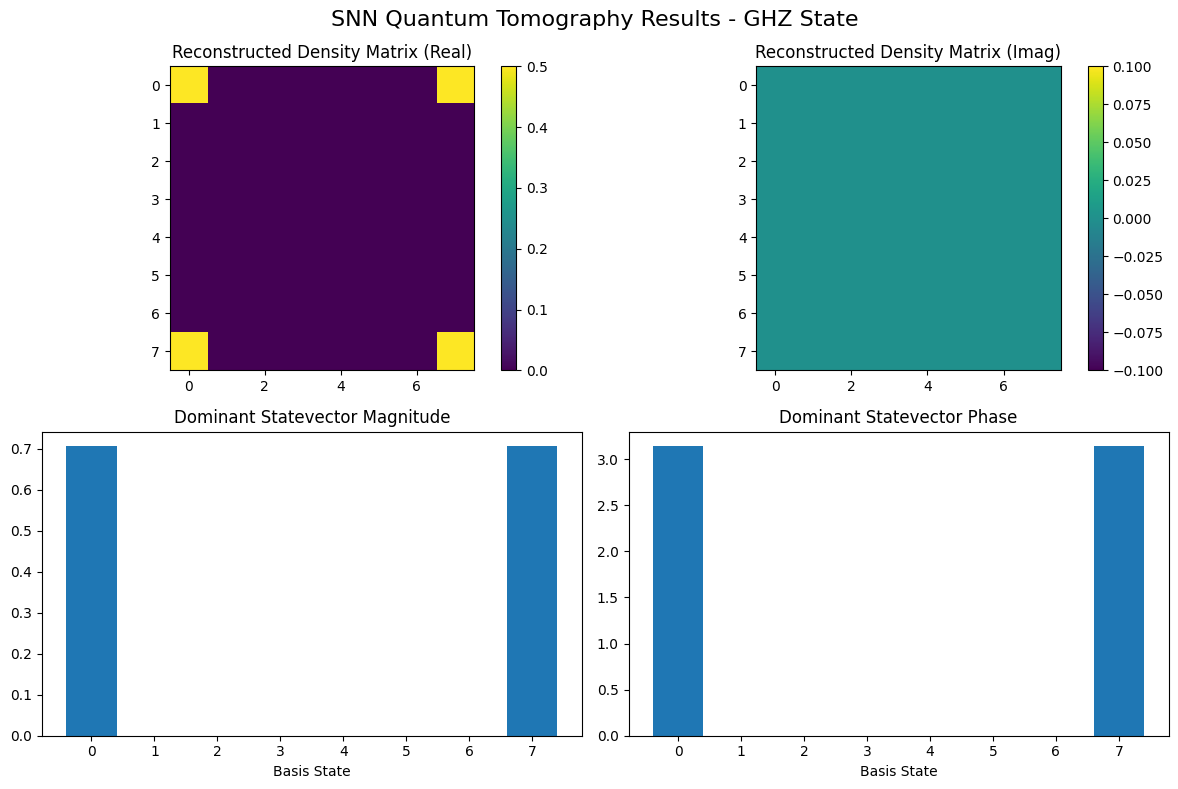

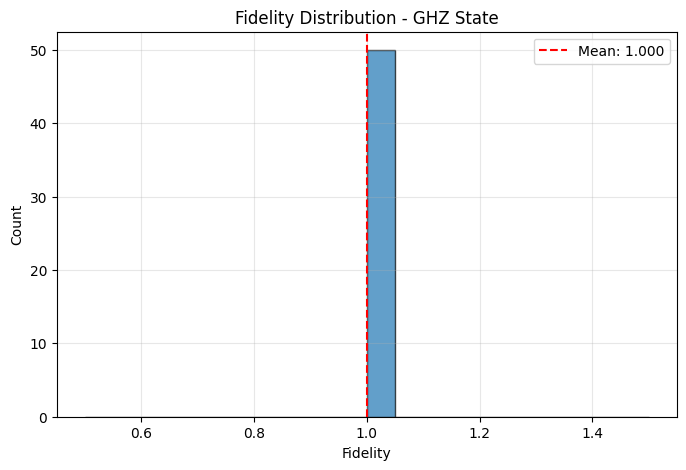


=== Testing on Additional Circuits ===
Testing: W State
  Fidelity: 0.5713
Testing: QFT |001⟩
  Fidelity: 0.2134
Testing: Random State
  Fidelity: 0.2521
=== Quantum State Tomography with Spiking Neural Networks ===
Circuit: Bell State
Device: cpu
Qubits: 2, Reservoir: 100, Time steps: 50
Training samples: 50, Measurement shots: 1000
Training regression model...
Training Results - Average fidelity: 1.0000 ± 0.0000


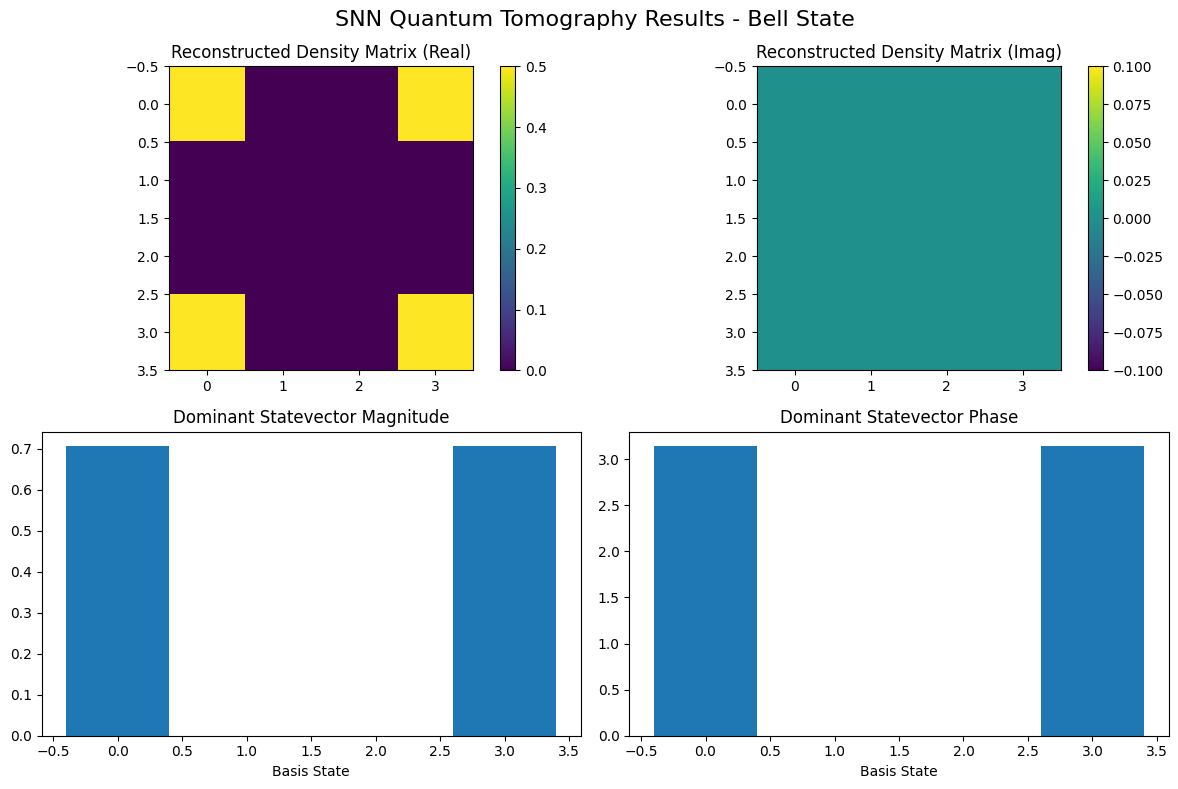

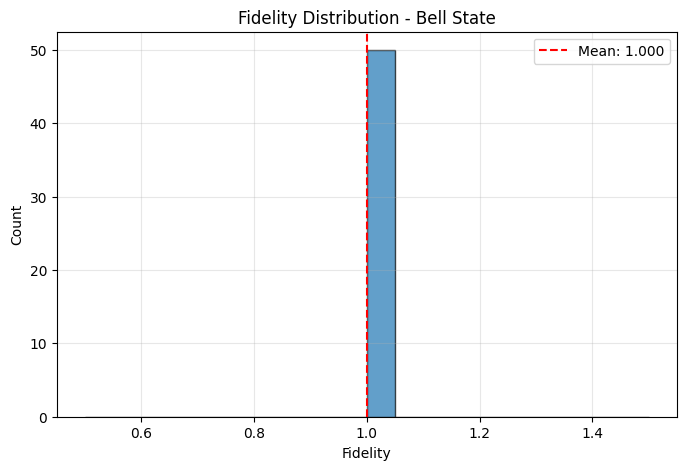


=== Testing on Additional Circuits ===
Testing: Random 2-qubit
  Fidelity: 0.1763

=== Summary ===
GHZ State Training Fidelity: 1.0000
Bell State Training Fidelity: 1.0000

GHZ Model Test Results:
  W State: 0.5713
  QFT |001⟩: 0.2134
  Random State: 0.2521


In [2]:
# Installation: pip install torch pennylane scikit-learn matplotlib numpy

import torch
import torch.nn as nn
import pennylane as qml
from pennylane import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from typing import Dict, Callable, Optional

def quantum_state_tomography_snn(
    circuit_func: Callable,
    num_qubits: int,
    circuit_name: str = "Unknown Circuit",
    reservoir_size: int = 100,
    time_steps: int = 50,
    num_training_samples: int = 50,
    measurement_shots: int = 1000,
    max_rate_hz: int = 100,
    test_circuits: Optional[Dict[str, Callable]] = None,
    visualize: bool = True
):
    """
    Performs quantum state tomography using spiking neural networks on any quantum circuit.

    Args:
        circuit_func: Function that defines the quantum circuit (no parameters)
        num_qubits: Number of qubits in the circuit
        circuit_name: Name of the circuit for display
        reservoir_size: Size of the spiking reservoir
        time_steps: Number of time steps for spike simulation
        num_training_samples: Number of training samples
        measurement_shots: Number of measurement shots per sample
        max_rate_hz: Maximum spike rate in Hz
        test_circuits: Dictionary of additional circuits to test
        visualize: Whether to show visualizations

    Returns:
        Dict with fidelity results and trained model
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_size = 2 ** num_qubits

    print(f"=== Quantum State Tomography with Spiking Neural Networks ===")
    print(f"Circuit: {circuit_name}")
    print(f"Device: {device}")
    print(f"Qubits: {num_qubits}, Reservoir: {reservoir_size}, Time steps: {time_steps}")
    print(f"Training samples: {num_training_samples}, Measurement shots: {measurement_shots}")

    # PennyLane devices
    dev_meas = qml.device("default.qubit", wires=num_qubits, shots=measurement_shots)
    dev_state = qml.device("default.qubit", wires=num_qubits, shots=None)

    @qml.qnode(dev_meas)
    def sample_measurement():
        circuit_func()
        return qml.sample(wires=range(num_qubits))

    @qml.qnode(dev_state)
    def prepare_state():
        circuit_func()
        return qml.state()

    def state_to_density_matrix(state_vec):
        return np.outer(state_vec, np.conj(state_vec))

    def samples_to_rates(samples, max_rate=max_rate_hz):
        """Convert measurement samples to spike rates"""
        counts = {}
        total = len(samples)
        for s in samples:
            bitstr = ''.join(str(int(b)) for b in s)
            counts[bitstr] = counts.get(bitstr, 0) + 1
        freqs = [counts.get(f"{i:0{num_qubits}b}", 0)/total for i in range(2**num_qubits)]
        return torch.tensor(freqs, dtype=torch.float) * max_rate

    def generate_poisson_spikes(rates, time_steps, dt=1.0):
        """Generate Poisson spike trains from rates"""
        prob = rates * dt / 1000
        prob = torch.clamp(prob, 0, 1)
        spikes = torch.rand(time_steps, len(rates)) < prob
        return spikes.float()

    class SNNReservoir(nn.Module):
        """Spiking Neural Network Reservoir"""
        def __init__(self, input_size, reservoir_size):
            super().__init__()
            self.input_size = input_size
            self.reservoir_size = reservoir_size

            # Network layers
            self.W_in = nn.Linear(input_size, reservoir_size, bias=False)
            self.W_rec = nn.Linear(reservoir_size, reservoir_size, bias=False)

            # LIF parameters
            self.beta = 0.9  # membrane decay
            self.threshold = 1.0

            # Initialize weights
            with torch.no_grad():
                self.W_rec.weight.data *= 0.5  # spectral radius control

        def forward(self, spike_inputs):
            batch_size = 1
            time_steps = spike_inputs.size(0)

            # Initialize states
            mem = torch.zeros(batch_size, self.reservoir_size, device=spike_inputs.device)
            spike_counts = torch.zeros(self.reservoir_size, device=spike_inputs.device)

            for t in range(time_steps):
                # Input current
                input_current = self.W_in(spike_inputs[t].unsqueeze(0))

                # Recurrent current
                rec_current = self.W_rec(spk) if t > 0 else 0

                # Update membrane potential
                mem = self.beta * mem + input_current + rec_current

                # Generate spikes
                spk = (mem >= self.threshold).float()
                spike_counts += spk.squeeze(0)

                # Reset membrane potential
                mem = mem * (1 - spk)

            return spike_counts / time_steps  # Average firing rates

    # Initialize reservoir
    reservoir = SNNReservoir(input_size, reservoir_size).to(device)

    # Training data collection
    reservoir_states = []
    target_density_mats = []

    print("Collecting training data...")
    for sample_idx in range(num_training_samples):
        # Generate measurement samples
        meas_samples = sample_measurement()
        spike_rates = samples_to_rates(meas_samples).to(device)

        # Generate spike trains
        spike_inputs = generate_poisson_spikes(spike_rates, time_steps).to(device)

        # Run through reservoir
        with torch.no_grad():
            firing_rates = reservoir(spike_inputs)

        reservoir_states.append(firing_rates.cpu().numpy())

        # Get true density matrix
        true_state = prepare_state()
        dm = state_to_density_matrix(true_state)
        target_density_mats.append(dm)

    reservoir_states = np.array(reservoir_states)
    target_density_mats = np.array(target_density_mats)

    # Prepare targets for regression
    dim = 2 ** num_qubits
    targets = np.hstack([target_density_mats.real.reshape(num_training_samples, -1),
                         target_density_mats.imag.reshape(num_training_samples, -1)])

    # Train regression model
    print("Training regression model...")
    regressor = Ridge()
    regressor.fit(reservoir_states, targets)
    predictions = regressor.predict(reservoir_states)

    # Fidelity evaluation
    def fidelity_batch(true_dm, pred_dm, dim=2**num_qubits):
        fidelities = []
        for t, p in zip(true_dm, pred_dm):
            t_dm = t[:dim*dim].reshape((dim, dim)) + 1j * t[dim*dim:].reshape((dim, dim))
            p_dm = p[:dim*dim].reshape((dim, dim)) + 1j * p[dim*dim:].reshape((dim, dim))
            fidelities.append(qml.math.fidelity(t_dm, p_dm))
        return np.array(fidelities)

    fidelities = fidelity_batch(targets, predictions)
    avg_fidelity = np.mean(fidelities)
    std_fidelity = np.std(fidelities)

    print(f"Training Results - Average fidelity: {avg_fidelity:.4f} ± {std_fidelity:.4f}")

    # Visualization
    if visualize:
        # Reconstructed density matrix visualization
        pred_dm = predictions[0, :dim*dim].reshape((dim, dim)) + 1j * predictions[0, dim*dim:].reshape((dim, dim))
        eigvals, eigvecs = np.linalg.eigh(pred_dm)
        dominant_vec = eigvecs[:, np.argmax(eigvals)]

        fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle(f'SNN Quantum Tomography Results - {circuit_name}', fontsize=16)

        im1 = axs[0, 0].imshow(pred_dm.real, cmap='viridis')
        axs[0, 0].set_title("Reconstructed Density Matrix (Real)")
        plt.colorbar(im1, ax=axs[0, 0])

        im2 = axs[0, 1].imshow(pred_dm.imag, cmap='viridis')
        axs[0, 1].set_title("Reconstructed Density Matrix (Imag)")
        plt.colorbar(im2, ax=axs[0, 1])

        axs[1, 0].bar(range(dim), np.abs(dominant_vec))
        axs[1, 0].set_title("Dominant Statevector Magnitude")
        axs[1, 0].set_xlabel("Basis State")

        axs[1, 1].bar(range(dim), np.angle(dominant_vec))
        axs[1, 1].set_title("Dominant Statevector Phase")
        axs[1, 1].set_xlabel("Basis State")

        plt.tight_layout()
        plt.show()

        # Fidelity distribution
        plt.figure(figsize=(8, 5))
        plt.hist(fidelities, bins=20, alpha=0.7, edgecolor='black')
        plt.xlabel('Fidelity')
        plt.ylabel('Count')
        plt.title(f'Fidelity Distribution - {circuit_name}')
        plt.axvline(avg_fidelity, color='red', linestyle='--',
                   label=f'Mean: {avg_fidelity:.3f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    results = {
        'circuit_name': circuit_name,
        'avg_fidelity': avg_fidelity,
        'std_fidelity': std_fidelity,
        'regressor': regressor,
        'reservoir': reservoir
    }

    # Test on additional circuits
    if test_circuits:
        print("\n=== Testing on Additional Circuits ===")
        test_results = {}

        for test_name, test_circuit in test_circuits.items():
            print(f"Testing: {test_name}")

            # Create test measurement and state devices
            dev_test_meas = qml.device("default.qubit", wires=num_qubits, shots=measurement_shots)
            dev_test_state = qml.device("default.qubit", wires=num_qubits, shots=None)

            @qml.qnode(dev_test_meas)
            def test_measurement():
                test_circuit()
                return qml.sample(wires=range(num_qubits))

            @qml.qnode(dev_test_state)
            def test_state():
                test_circuit()
                return qml.state()

            # Generate test data
            meas_samples = test_measurement()
            spike_rates = samples_to_rates(meas_samples).to(device)
            spike_inputs = generate_poisson_spikes(spike_rates, time_steps).to(device)

            # Run through trained reservoir
            with torch.no_grad():
                test_firing = reservoir(spike_inputs)

            # Predict using trained regressor
            pred_test = regressor.predict(test_firing.cpu().numpy().reshape(1, -1))

            # Get true state
            true_state_test = test_state()
            true_dm_test = state_to_density_matrix(true_state_test)
            target_test = np.hstack([true_dm_test.real.reshape(1, -1),
                                   true_dm_test.imag.reshape(1, -1)])

            # Calculate fidelity
            test_fidelity = fidelity_batch(target_test, pred_test)[0]
            test_results[test_name] = test_fidelity

            print(f"  Fidelity: {test_fidelity:.4f}")

        results['test_results'] = test_results

    return results

# Example quantum circuits
def ghz_state(num_qubits):
    def circuit():
        qml.Hadamard(wires=0)
        for i in range(num_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    return circuit

def bell_state():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])

def w_state():
    qml.RY(np.arccos(np.sqrt(2/3)), wires=0)
    qml.ctrl(qml.RY(np.arccos(np.sqrt(1/2)), wires=1), control=0)
    qml.ctrl(qml.PauliX(wires=2), control=[0, 1])

def qft_state(num_qubits):
    def circuit():
        # Apply initial state |001⟩
        qml.PauliX(wires=num_qubits-1)
        # Apply QFT
        for qubit in range(num_qubits):
            qml.Hadamard(wires=qubit)
            for j in range(qubit+1, num_qubits):
                qml.CRZ(np.pi / 2**(j-qubit), wires=[j, qubit])
    return circuit

def random_state(num_qubits):
    def circuit():
        for qubit in range(num_qubits):
            qml.RY(np.random.uniform(0, 2*np.pi), wires=qubit)
            qml.RZ(np.random.uniform(0, 2*np.pi), wires=qubit)
        for i in range(num_qubits-1):
            qml.CNOT(wires=[i, i+1])
    return circuit

# Usage examples
if __name__ == "__main__":
    # Test GHZ state with multiple other circuits
    results_ghz = quantum_state_tomography_snn(
        circuit_func=ghz_state(3),
        num_qubits=3,
        circuit_name="GHZ State",
        test_circuits={
            "W State": w_state,
            "QFT |001⟩": qft_state(3),
            "Random State": random_state(3)
        }
    )

    # Test Bell state (2-qubit)
    results_bell = quantum_state_tomography_snn(
        circuit_func=bell_state,
        num_qubits=2,
        circuit_name="Bell State",
        test_circuits={
            "Random 2-qubit": random_state(2)
        }
    )

    print("\n=== Summary ===")
    print(f"GHZ State Training Fidelity: {results_ghz['avg_fidelity']:.4f}")
    print(f"Bell State Training Fidelity: {results_bell['avg_fidelity']:.4f}")

    if 'test_results' in results_ghz:
        print("\nGHZ Model Test Results:")
        for circuit, fidelity in results_ghz['test_results'].items():
            print(f"  {circuit}: {fidelity:.4f}")


In [ ]:
# Installation: pip install torch pennylane scikit-learn matplotlib numpy scipy

import torch
import torch.nn as nn
import pennylane as qml
from pennylane import numpy as np
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from typing import Callable, Optional, Dict, List, Tuple
from dataclasses import dataclass
from scipy.optimize import differential_evolution
import random

@dataclass
class OptimizedLSMConfig:
    """Configuration for optimized neuromorphic LSM"""
    # Network architecture
    reservoir_size: int = 200
    input_size: int = 8
    time_steps: int = 100

    # Neuron diversity
    excitatory_ratio: float = 0.8  # 80% excitatory, 20% inhibitory
    neuron_types: List[str] = None  # ['regular', 'fast', 'adaptive']

    # Connection parameters
    input_connectivity: float = 0.3
    recurrent_connectivity: float = 0.1
    spectral_radius: float = 0.95

    # Neuron dynamics
    membrane_decay_range: Tuple[float, float] = (0.85, 0.95)
    threshold_range: Tuple[float, float] = (0.8, 1.2)
    refractory_period: int = 2

    # Input encoding
    max_rate_hz: float = 100
    encoding_method: str = 'poisson'  # 'poisson', 'rate', 'temporal'

    # Learning parameters
    plasticity_enabled: bool = False
    homeostasis_enabled: bool = True

class OptimizedNeuronGroup(nn.Module):
    """Optimized neuron group with multiple neuron types"""

    def __init__(self, size: int, config: OptimizedLSMConfig, neuron_type: str = 'regular'):
        super().__init__()
        self.size = size
        self.neuron_type = neuron_type
        self.config = config

        # Neuron-specific parameters
        if neuron_type == 'regular':
            self.decay_factor = torch.tensor(np.random.uniform(*config.membrane_decay_range, size))
            self.threshold = torch.tensor(np.random.uniform(*config.threshold_range, size))
            self.refractory = config.refractory_period
        elif neuron_type == 'fast':
            self.decay_factor = torch.tensor(np.random.uniform(0.7, 0.85, size))
            self.threshold = torch.tensor(np.random.uniform(0.6, 0.9, size))
            self.refractory = 1
        elif neuron_type == 'adaptive':
            self.decay_factor = torch.tensor(np.random.uniform(0.9, 0.98, size))
            self.threshold = torch.tensor(np.random.uniform(1.0, 1.5, size))
            self.refractory = 3

        # Homeostasis parameters
        if config.homeostasis_enabled:
            self.target_rate = 0.1  # Target firing rate
            self.adaptation_rate = 0.001

        # State variables
        self.membrane = torch.zeros(size)
        self.refractory_count = torch.zeros(size)
        self.spike_history = []

    def forward(self, input_current: torch.Tensor) -> torch.Tensor:
        """Update neuron states and return spikes"""
        # Update refractory counters
        self.refractory_count = torch.maximum(self.refractory_count - 1, torch.zeros_like(self.refractory_count))

        # Update membrane potential (only non-refractory neurons)
        non_refractory = self.refractory_count == 0
        self.membrane = self.membrane * self.decay_factor + input_current * non_refractory.float()

        # Generate spikes
        spikes = (self.membrane >= self.threshold) & non_refractory

        # Reset membrane and set refractory period
        self.membrane[spikes] = 0
        self.refractory_count[spikes] = self.refractory

        # Homeostatic adaptation
        if self.config.homeostasis_enabled:
            recent_rate = torch.mean(torch.stack(self.spike_history[-10:]) if len(self.spike_history) >= 10
                                   else torch.stack(self.spike_history) if self.spike_history else torch.zeros(1))
            self.threshold += self.adaptation_rate * (recent_rate - self.target_rate)
            self.threshold = torch.clamp(self.threshold, 0.1, 2.0)

        # Store spike history
        self.spike_history.append(spikes.float())
        if len(self.spike_history) > 50:
            self.spike_history.pop(0)

        return spikes.float()

class OptimizedNeuromorphicLSM(nn.Module):
    """Optimized Liquid State Machine with heterogeneous neurons"""

    def __init__(self, config: OptimizedLSMConfig):
        super().__init__()
        self.config = config

        # Create neuron groups
        self.neuron_groups = self._create_neuron_groups()

        # Create connection matrices
        self.W_in = self._create_input_weights()
        self.W_rec = self._create_recurrent_weights()

        # Activity tracking
        self.reset_activity_tracking()

    def _create_neuron_groups(self) -> Dict[str, OptimizedNeuronGroup]:
        """Create diverse neuron groups"""
        groups = {}

        # Determine group sizes
        excitatory_size = int(self.config.reservoir_size * self.config.excitatory_ratio)
        inhibitory_size = self.config.reservoir_size - excitatory_size

        # Create excitatory neurons (mixture of types)
        regular_size = int(excitatory_size * 0.6)
        fast_size = int(excitatory_size * 0.3)
        adaptive_size = excitatory_size - regular_size - fast_size

        groups['excitatory_regular'] = OptimizedNeuronGroup(regular_size, self.config, 'regular')
        groups['excitatory_fast'] = OptimizedNeuronGroup(fast_size, self.config, 'fast')
        groups['excitatory_adaptive'] = OptimizedNeuronGroup(adaptive_size, self.config, 'adaptive')
        groups['inhibitory'] = OptimizedNeuronGroup(inhibitory_size, self.config, 'fast')

        return groups

    def _create_input_weights(self) -> torch.Tensor:
        """Create optimized input connection matrix"""
        W_in = torch.zeros(self.config.reservoir_size, self.config.input_size)

        # Random sparse connections
        for i in range(self.config.reservoir_size):
            if torch.rand(1) < self.config.input_connectivity:
                # Select random input connections
                n_connections = torch.randint(1, min(4, self.config.input_size + 1), (1,))
                input_indices = torch.randperm(self.config.input_size)[:n_connections]
                W_in[i, input_indices] = torch.randn(n_connections) * 0.5

        return W_in

    def _create_recurrent_weights(self) -> torch.Tensor:
        """Create recurrent connection matrix with proper spectral radius"""
        W_rec = torch.zeros(self.config.reservoir_size, self.config.reservoir_size)

        # Create sparse random connections
        mask = torch.rand(self.config.reservoir_size, self.config.reservoir_size) < self.config.recurrent_connectivity
        W_rec[mask] = torch.randn(mask.sum()) * 0.5

        # Set excitatory/inhibitory weights
        excitatory_size = int(self.config.reservoir_size * self.config.excitatory_ratio)
        W_rec[:, excitatory_size:] *= -1  # Inhibitory connections are negative

        # Normalize spectral radius
        eigenvalues = torch.linalg.eigvals(W_rec)
        current_spectral_radius = torch.max(torch.abs(eigenvalues)).real
        if current_spectral_radius > 0:
            W_rec *= self.config.spectral_radius / current_spectral_radius

        return W_rec

    def reset_activity_tracking(self):
        """Reset activity tracking variables"""
        self.spike_trains = []
        self.membrane_potentials = []
        self.firing_rates = torch.zeros(self.config.reservoir_size)

    def forward(self, spike_inputs: torch.Tensor, track_activity: bool = False) -> torch.Tensor:
        """Forward pass through optimized LSM"""
        time_steps = spike_inputs.size(0)

        if track_activity:
            self.reset_activity_tracking()

        # Initialize states
        total_spikes = torch.zeros(self.config.reservoir_size)

        for t in range(time_steps):
            # Input current
            input_current = torch.matmul(self.W_in, spike_inputs[t])

            # Recurrent current from previous timestep
            if t > 0:
                rec_current = torch.matmul(self.W_rec, current_spikes)
            else:
                rec_current = torch.zeros_like(input_current)

            # Update neuron groups
            all_spikes = []
            group_start = 0

            for group_name, group in self.neuron_groups.items():
                group_end = group_start + group.size
                group_input = input_current[group_start:group_end] + rec_current[group_start:group_end]
                group_spikes = group(group_input)
                all_spikes.append(group_spikes)
                group_start = group_end

            current_spikes = torch.cat(all_spikes)
            total_spikes += current_spikes

            # Track activity
            if track_activity:
                self.spike_trains.append(current_spikes.clone())
                # Collect membrane potentials
                all_membranes = torch.cat([group.membrane for group in self.neuron_groups.values()])
                self.membrane_potentials.append(all_membranes.clone())

        # Calculate firing rates
        self.firing_rates = total_spikes / time_steps
        return self.firing_rates

def create_fixed_random_circuit(num_qubits: int, depth: int = 3, seed: int = 42) -> Tuple[Callable, np.ndarray]:
    """Create a fixed random quantum circuit with known amplitudes"""
    np.random.seed(seed)
    random.seed(seed)

    # Generate random but fixed amplitudes for real amplitude encoding
    amplitudes = np.random.randn(2**num_qubits)
    amplitudes = amplitudes / np.linalg.norm(amplitudes)  # Normalize

    def circuit():
        # Use AmplitudeEmbedding for real amplitude encoding
        qml.AmplitudeEmbedding(amplitudes, wires=range(num_qubits), normalize=True)

    return circuit, amplitudes

def advanced_poisson_encoding(measurement_probs: np.ndarray, config: OptimizedLSMConfig) -> torch.Tensor:
    """Advanced Poisson spike encoding with temporal patterns"""

    if config.encoding_method == 'poisson':
        # Standard Poisson encoding
        rates = torch.tensor(measurement_probs) * config.max_rate_hz
        prob_per_step = rates / 1000.0  # Convert Hz to probability per ms
        prob_per_step = torch.clamp(prob_per_step, 0, 1)
        spikes = torch.rand(config.time_steps, len(rates)) < prob_per_step
        return spikes.float()

    elif config.encoding_method == 'temporal':
        # Temporal encoding with burst patterns
        spikes = torch.zeros(config.time_steps, len(measurement_probs))
        for i, prob in enumerate(measurement_probs):
            if prob > 0:
                # Create burst pattern
                n_spikes = int(prob * config.max_rate_hz * config.time_steps / 1000)
                if n_spikes > 0:
                    # Generate burst times
                    burst_centers = torch.randint(0, config.time_steps, (max(1, n_spikes // 3),))
                    for center in burst_centers:
                        burst_size = min(3, n_spikes)
                        for offset in range(-(burst_size//2), (burst_size//2)+1):
                            time_idx = torch.clamp(center + offset, 0, config.time_steps-1)
                            spikes[time_idx, i] = 1
                            n_spikes -= 1
                            if n_spikes <= 0:
                                break
        return spikes

    else:  # 'rate' encoding
        # Rate-based encoding
        rates = torch.tensor(measurement_probs) * config.max_rate_hz / 1000
        spikes = torch.rand(config.time_steps, len(rates)) < rates.unsqueeze(0)
        return spikes.float()

def optimize_lsm_architecture(
    circuit_func: Callable,
    true_amplitudes: np.ndarray,
    num_qubits: int,
    num_samples: int = 30
) -> OptimizedLSMConfig:
    """Optimize LSM architecture using evolutionary algorithms"""

    print("Optimizing LSM architecture...")

    def objective_function(params):
        """Objective function for optimization"""
        reservoir_size, spectral_radius, connectivity, max_rate, decay_min, decay_max = params

        config = OptimizedLSMConfig(
            reservoir_size=int(reservoir_size),
            input_size=2**num_qubits,
            recurrent_connectivity=connectivity,
            spectral_radius=spectral_radius,
            max_rate_hz=max_rate,
            membrane_decay_range=(decay_min, decay_max)
        )

        try:
            # Quick evaluation with reduced samples
            result = evaluate_lsm_performance(circuit_func, true_amplitudes, num_qubits, config, num_samples//2)
            return -result['fidelity']  # Minimize negative fidelity
        except Exception as e:
            print(f"Error in optimization: {e}")
            return 1.0  # High penalty for failed configurations

    # Parameter bounds: [reservoir_size, spectral_radius, connectivity, max_rate, decay_min, decay_max]
    bounds = [
        (50, 300),      # reservoir_size
        (0.5, 1.2),     # spectral_radius
        (0.05, 0.3),    # recurrent_connectivity
        (50, 200),      # max_rate_hz
        (0.7, 0.9),     # decay_min
        (0.85, 0.98)    # decay_max
    ]

    # Run optimization
    result = differential_evolution(
        objective_function,
        bounds,
        maxiter=10,  # Reduced for faster execution
        popsize=8,
        seed=42,
        disp=True
    )

    # Extract optimized parameters
    opt_params = result.x
    optimized_config = OptimizedLSMConfig(
        reservoir_size=int(opt_params[0]),
        input_size=2**num_qubits,
        recurrent_connectivity=opt_params[2],
        spectral_radius=opt_params[1],
        max_rate_hz=opt_params[3],
        membrane_decay_range=(opt_params[4], opt_params[5])
    )

    print(f"Optimization complete. Best fidelity: {-result.fun:.4f}")
    print(f"Optimized config: reservoir_size={optimized_config.reservoir_size}, "
          f"spectral_radius={optimized_config.spectral_radius:.3f}, "
          f"connectivity={optimized_config.recurrent_connectivity:.3f}")

    return optimized_config

def evaluate_lsm_performance(
    circuit_func: Callable,
    true_amplitudes: np.ndarray,
    num_qubits: int,
    config: OptimizedLSMConfig,
    num_samples: int = 50
) -> Dict:
    """Evaluate LSM performance on quantum circuit"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # PennyLane setup
    dev_meas = qml.device("default.qubit", wires=num_qubits, shots=1000)

    @qml.qnode(dev_meas)
    def sample_measurement():
        circuit_func()
        return qml.sample(wires=range(num_qubits))

    # Initialize optimized LSM
    lsm = OptimizedNeuromorphicLSM(config).to(device)

    # Collect data
    reservoir_states = []
    target_amplitudes = []

    for _ in range(num_samples):
        # Generate measurement samples
        meas_samples = sample_measurement()

        # Convert to probability distribution
        counts = {}
        total = len(meas_samples)
        for s in meas_samples:
            bitstr = ''.join(str(int(b)) for b in s)
            counts[bitstr] = counts.get(bitstr, 0) + 1

        probs = np.array([counts.get(f"{i:0{num_qubits}b}", 0) / total for i in range(2**num_qubits)])

        # Encode as spikes
        spike_inputs = advanced_poisson_encoding(probs, config).to(device)

        # Run through LSM
        with torch.no_grad():
            firing_rates = lsm(spike_inputs)

        reservoir_states.append(firing_rates.cpu().numpy())
        target_amplitudes.append(true_amplitudes)

    # Train regressor
    X = np.array(reservoir_states)
    y = np.array(target_amplitudes)

    regressor = ElasticNet(alpha=0.1, l1_ratio=0.5)
    regressor.fit(X, y)

    y_pred = regressor.predict(X)

    # Calculate metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Fidelity calculation for real amplitudes
    fidelity = np.mean([np.abs(np.dot(y_true / np.linalg.norm(y_true),
                                     y_p / np.linalg.norm(y_p)))**2
                       for y_true, y_p in zip(y, y_pred)])

    return {
        'mse': mse,
        'r2': r2,
        'fidelity': fidelity,
        'regressor': regressor,
        'lsm': lsm,
        'config': config
    }

def comprehensive_testing_analysis(
    num_qubits: int = 3,
    circuit_depth: int = 3,
    num_test_samples: int = 50
):
    """Comprehensive testing and analysis of optimized neuromorphic LSM"""

    print(f"=== Comprehensive Testing: {num_qubits}-qubit Random Circuit ===")

    # Create fixed random circuit
    circuit_func, true_amplitudes = create_fixed_random_circuit(num_qubits, circuit_depth)

    print(f"True amplitudes: {true_amplitudes}")
    print(f"Amplitude norm: {np.linalg.norm(true_amplitudes)}")

    # Test baseline configuration
    baseline_config = OptimizedLSMConfig(
        reservoir_size=150,
        input_size=2**num_qubits,
        time_steps=80,
        max_rate_hz=100
    )

    print("\n--- Baseline Performance ---")
    baseline_result = evaluate_lsm_performance(circuit_func, true_amplitudes, num_qubits,
                                             baseline_config, num_test_samples)

    print(f"Baseline - Fidelity: {baseline_result['fidelity']:.4f}, "
          f"MSE: {baseline_result['mse']:.6f}, R²: {baseline_result['r2']:.4f}")

    # Optimize architecture
    print("\n--- Architecture Optimization ---")
    optimized_config = optimize_lsm_architecture(circuit_func, true_amplitudes, num_qubits, num_test_samples)

    # Test optimized configuration
    print("\n--- Optimized Performance ---")
    optimized_result = evaluate_lsm_performance(circuit_func, true_amplitudes, num_qubits,
                                              optimized_config, num_test_samples)

    print(f"Optimized - Fidelity: {optimized_result['fidelity']:.4f}, "
          f"MSE: {optimized_result['mse']:.6f}, R²: {optimized_result['r2']:.4f}")

    # Performance comparison
    improvement = (optimized_result['fidelity'] - baseline_result['fidelity']) / baseline_result['fidelity'] * 100
    print(f"\nImprovement: {improvement:.1f}% fidelity increase")

    # Detailed analysis of optimized LSM
    analyze_optimized_lsm(optimized_result['lsm'], circuit_func, optimized_config, true_amplitudes)

    # Create comprehensive visualizations
    create_comprehensive_visualizations(baseline_result, optimized_result, true_amplitudes)

    return baseline_result, optimized_result

def analyze_optimized_lsm(lsm: OptimizedNeuromorphicLSM, circuit_func: Callable,
                         config: OptimizedLSMConfig, true_amplitudes: np.ndarray):
    """Analyze the optimized LSM in detail"""

    print("\n--- Detailed LSM Analysis ---")

    # Run with activity tracking
    dev_meas = qml.device("default.qubit", wires=len(true_amplitudes).bit_length()-1, shots=1000)

    @qml.qnode(dev_meas)
    def sample_measurement():
        circuit_func()
        return qml.sample(wires=range(len(true_amplitudes).bit_length()-1))

    # Generate sample input
    meas_samples = sample_measurement()
    counts = {}
    total = len(meas_samples)
    for s in meas_samples:
        bitstr = ''.join(str(int(b)) for b in s)
        counts[bitstr] = counts.get(bitstr, 0) + 1

    probs = np.array([counts.get(f"{i:0{len(true_amplitudes).bit_length()-1}b}", 0) / total
                     for i in range(len(true_amplitudes))])

    spike_inputs = advanced_poisson_encoding(probs, config)

    # Run with tracking
    with torch.no_grad():
        firing_rates = lsm(spike_inputs, track_activity=True)

    # Analyze neuron groups
    print("\nNeuron Group Analysis:")
    group_start = 0
    for group_name, group in lsm.neuron_groups.items():
        group_end = group_start + group.size
        group_rates = firing_rates[group_start:group_end]
        active_neurons = torch.sum(group_rates > 0).item()
        avg_rate = torch.mean(group_rates).item()

        print(f"  {group_name}: {active_neurons}/{group.size} active "
              f"({active_neurons/group.size*100:.1f}%), avg rate: {avg_rate:.4f}")

        group_start = group_end

    # Overall statistics
    total_active = torch.sum(firing_rates > 0).item()
    total_neurons = config.reservoir_size

    print(f"\nOverall Activity:")
    print(f"  Active neurons: {total_active}/{total_neurons} ({total_active/total_neurons*100:.1f}%)")
    print(f"  Mean firing rate: {torch.mean(firing_rates):.4f}")
    print(f"  Std firing rate: {torch.std(firing_rates):.4f}")
    print(f"  Max firing rate: {torch.max(firing_rates):.4f}")

def create_comprehensive_visualizations(baseline_result: Dict, optimized_result: Dict,
                                      true_amplitudes: np.ndarray):
    """Create comprehensive visualization comparing baseline vs optimized"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Neuromorphic LSM Optimization Results', fontsize=16, fontweight='bold')

    # Get predictions
    baseline_pred = baseline_result['regressor'].predict(
        np.array([baseline_result['lsm'].firing_rates.cpu().numpy()]))
    optimized_pred = optimized_result['regressor'].predict(
        np.array([optimized_result['lsm'].firing_rates.cpu().numpy()]))

    # Plot 1: True vs Predicted Amplitudes
    x_pos = np.arange(len(true_amplitudes))
    width = 0.25

    axes[0, 0].bar(x_pos - width, true_amplitudes, width, label='True', alpha=0.8, color='blue')
    axes[0, 0].bar(x_pos, baseline_pred[0], width, label='Baseline', alpha=0.8, color='orange')
    axes[0, 0].bar(x_pos + width, optimized_pred[0], width, label='Optimized', alpha=0.8, color='green')
    axes[0, 0].set_title('Amplitude Reconstruction Comparison')
    axes[0, 0].set_xlabel('Basis State')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Firing Rate Distributions
    baseline_rates = baseline_result['lsm'].firing_rates.cpu().numpy()
    optimized_rates = optimized_result['lsm'].firing_rates.cpu().numpy()

    axes[0, 1].hist(baseline_rates, bins=30, alpha=0.7, label='Baseline', color='orange')
    axes[0, 1].hist(optimized_rates, bins=30, alpha=0.7, label='Optimized', color='green')
    axes[0, 1].set_title('Firing Rate Distributions')
    axes[0, 1].set_xlabel('Firing Rate')
    axes[0, 1].set_ylabel('Number of Neurons')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Performance Metrics
    metrics = ['Fidelity', 'R²', '1-MSE']
    baseline_metrics = [baseline_result['fidelity'], baseline_result['r2'], 1-baseline_result['mse']]
    optimized_metrics = [optimized_result['fidelity'], optimized_result['r2'], 1-optimized_result['mse']]

    x_metrics = np.arange(len(metrics))
    axes[0, 2].bar(x_metrics - 0.2, baseline_metrics, 0.4, label='Baseline', color='orange')
    axes[0, 2].bar(x_metrics + 0.2, optimized_metrics, 0.4, label='Optimized', color='green')
    axes[0, 2].set_title('Performance Metrics Comparison')
    axes[0, 2].set_xticks(x_metrics)
    axes[0, 2].set_xticklabels(metrics)
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Plot 4: Network Architecture Comparison
    config_baseline = baseline_result['config']
    config_optimized = optimized_result['config']

    arch_params = ['Reservoir Size', 'Spectral Radius', 'Connectivity', 'Max Rate (Hz)']
    baseline_arch = [config_baseline.reservoir_size/100, config_baseline.spectral_radius,
                    config_baseline.recurrent_connectivity*10, config_baseline.max_rate_hz/100]
    optimized_arch = [config_optimized.reservoir_size/100, config_optimized.spectral_radius,
                     config_optimized.recurrent_connectivity*10, config_optimized.max_rate_hz/100]

    x_arch = np.arange(len(arch_params))
    axes[1, 0].bar(x_arch - 0.2, baseline_arch, 0.4, label='Baseline', color='orange')
    axes[1, 0].bar(x_arch + 0.2, optimized_arch, 0.4, label='Optimized', color='green')
    axes[1, 0].set_title('Architecture Parameters (Scaled)')
    axes[1, 0].set_xticks(x_arch)
    axes[1, 0].set_xticklabels(arch_params, rotation=45)
    axes[1, 0].set_ylabel('Scaled Value')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 5: Error Analysis
    baseline_error = np.abs(true_amplitudes - baseline_pred[0])
    optimized_error = np.abs(true_amplitudes - optimized_pred[0])

    axes[1, 1].bar(x_pos - width/2, baseline_error, width, label='Baseline Error', alpha=0.8, color='orange')
    axes[1, 1].bar(x_pos + width/2, optimized_error, width, label='Optimized Error', alpha=0.8, color='green')
    axes[1, 1].set_title('Absolute Error per Amplitude')
    axes[1, 1].set_xlabel('Basis State')
    axes[1, 1].set_ylabel('Absolute Error')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Plot 6: Improvement Summary
    improvements = [
        (optimized_result['fidelity'] - baseline_result['fidelity']) / baseline_result['fidelity'] * 100,
        (optimized_result['r2'] - baseline_result['r2']) / abs(baseline_result['r2']) * 100,
        -(optimized_result['mse'] - baseline_result['mse']) / baseline_result['mse'] * 100
    ]

    colors = ['green' if imp > 0 else 'red' for imp in improvements]
    axes[1, 2].bar(['Fidelity', 'R²', 'MSE'], improvements, color=colors, alpha=0.7)
    axes[1, 2].set_title('Performance Improvement (%)')
    axes[1, 2].set_ylabel('Improvement (%)')
    axes[1, 2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    print("=== Neuromorphic LSM Optimization for Quantum State Tomography ===")
    print("Testing on fixed random circuits with real amplitude encoding")

    # Test different qubit sizes
    for num_qubits in [2, 3]:
        print(f"\n{'='*80}")
        print(f"TESTING {num_qubits}-QUBIT SYSTEM")
        print(f"{'='*80}")

        baseline_result, optimized_result = comprehensive_testing_analysis(
            num_qubits=num_qubits,
            circuit_depth=3,
            num_test_samples=30
        )

        # Summary
        improvement = (optimized_result['fidelity'] - baseline_result['fidelity']) / baseline_result['fidelity'] * 100
        print(f"\n{num_qubits}-qubit Summary:")
        print(f"  Baseline fidelity: {baseline_result['fidelity']:.4f}")
        print(f"  Optimized fidelity: {optimized_result['fidelity']:.4f}")
        print(f"  Improvement: {improvement:.1f}%")

    print(f"\n{'='*80}")
    print("OPTIMIZATION COMPLETE")
    print(f"{'='*80}")
